In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

Text(0.5, 1.0, 'For epoch in (1,3,5)')

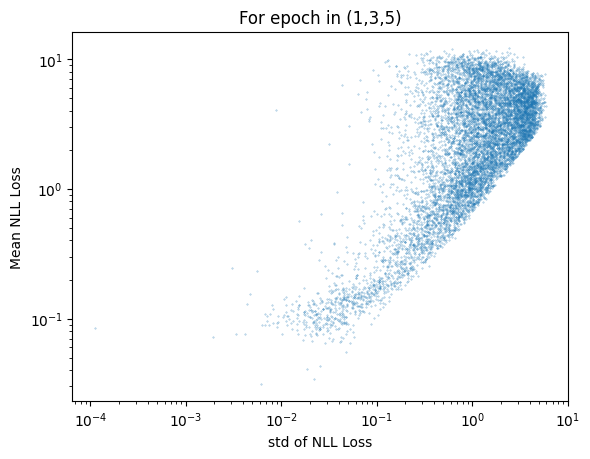

In [57]:
df = pd.read_csv('early_dynamics_output.csv')

n_examples = df["example_id"].nunique()
df["epoch"] = df.groupby("example_id").cumcount()

filt = 'epoch in (1,3,5)' # 'epoch <= 20' # 
df = df.query(filt)

# Group by example_id and calculate mean and std of perplexity
agg_df = df.groupby('example_id').agg({'nll_loss': ['mean', 'std', lambda x: x.max() - x.min(), lambda x: x.quantile(0.75) - x.quantile(0.25)], 'accuracy': ['mean']})

# sample
agg_df = agg_df.sample(n=10_000, random_state=42)

# Flatten the column names for easier access
agg_df.columns = ['mean_nll_loss', 'std_nll_loss', 'range_nll_loss', 'iqr_nll_loss', 'mean_accuracy']

# Reset index to make example_id a regular column
agg_df = agg_df.reset_index()


plt.scatter(agg_df['std_nll_loss'], agg_df['mean_nll_loss'], alpha=0.6, s=0.1)
plt.xlabel('std of NLL Loss')
plt.ylabel('Mean NLL Loss')

plt.yscale('log')
plt.xscale('log')
plt.title(f'For {filt}')

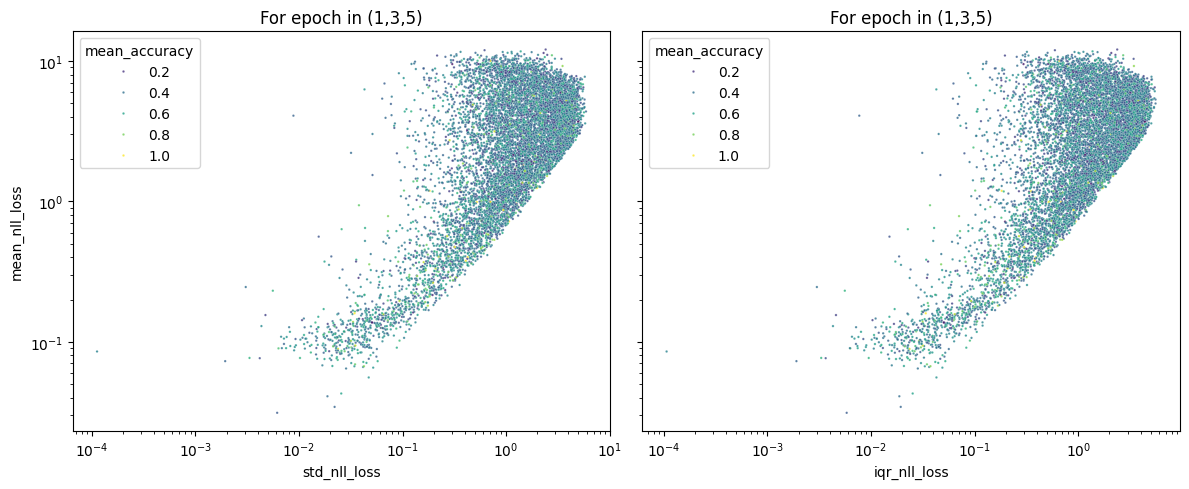

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.scatterplot(agg_df, x = "std_nll_loss", y = "mean_nll_loss", hue="mean_accuracy", alpha=0.8, s=3, palette="viridis", ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title(f'For {filt}')

sns.scatterplot(agg_df, x = "iqr_nll_loss", y = "mean_nll_loss", hue="mean_accuracy", alpha=0.8, s=3, palette="viridis", ax=ax2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title(f'For {filt}')

f.tight_layout()

Text(0.5, 1.0, 'For epoch in (1,3,5)')

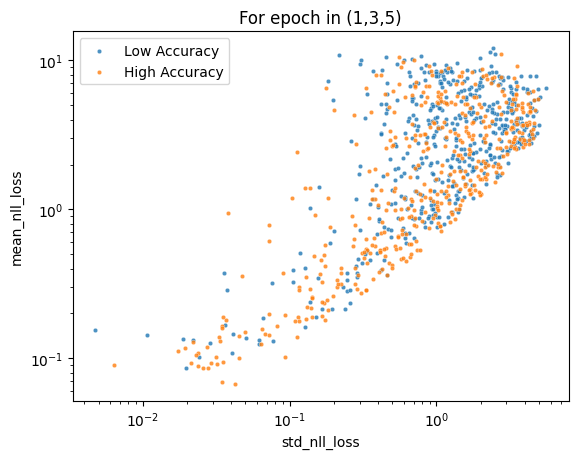

In [59]:
l, u = agg_df['mean_accuracy'].quantile([0.05, 0.95])
sns.scatterplot(agg_df.query(f'mean_accuracy < {l}'), x = "std_nll_loss", y = "mean_nll_loss", alpha=0.8, s=10, label="Low Accuracy")
sns.scatterplot(agg_df.query(f'mean_accuracy > {u}'), x = "std_nll_loss", y = "mean_nll_loss", alpha=0.8, s=10, label="High Accuracy")
plt.xscale('log')
plt.yscale('log')
plt.title(f'For {filt}')

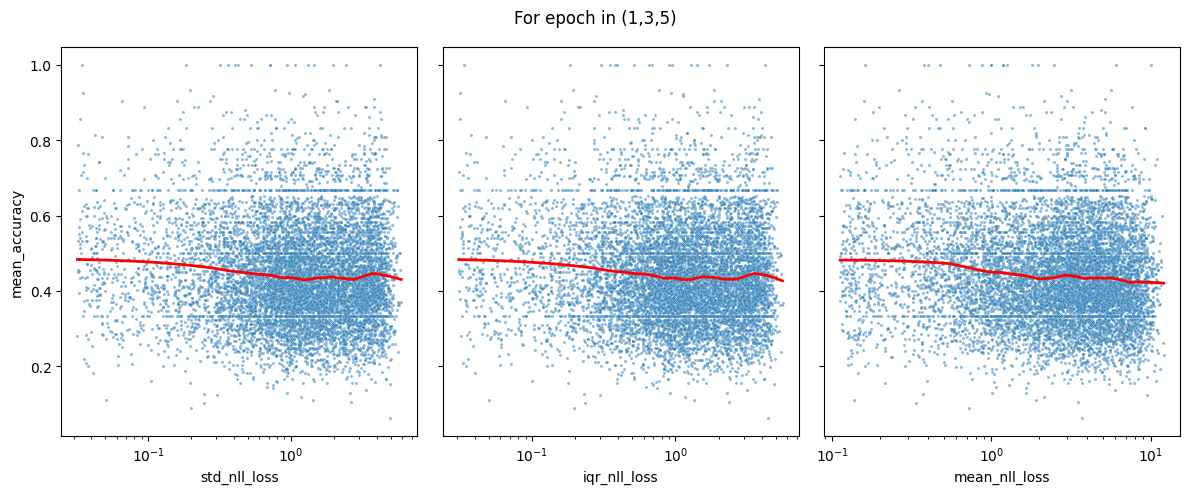

In [60]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for ax, x_col in [(ax1, 'std_nll_loss'), (ax2, 'iqr_nll_loss'), (ax3, 'mean_nll_loss')]:

    l = agg_df[x_col].quantile(0.05)
    tmp = agg_df.query(f'{x_col} > {l}')

    lowess_result = lowess(tmp['mean_accuracy'], tmp[x_col], frac=0.2, it=0, return_sorted=True)
    ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=2)
    sns.scatterplot(tmp, x = x_col, y = "mean_accuracy", alpha=0.5, s=5, ax=ax)

    ax.set_xscale('log')

f.suptitle(f'For {filt}')
f.tight_layout()

Text(0.5, 1.0, 'For epoch in (1,3,5)')

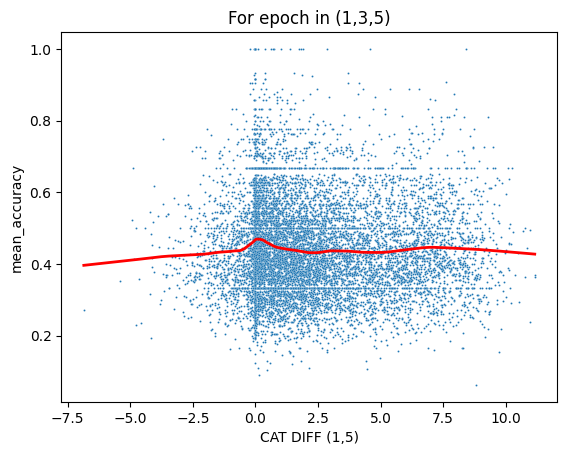

In [61]:
# Split into epoch 1 and 5
ep1 = df[df["epoch"] == 1][["example_id", "nll_loss"]].rename(columns={"nll_loss": "ppl_ep1"})
ep5 = df[df["epoch"] == 5][["example_id", "nll_loss"]].rename(columns={"nll_loss": "ppl_ep5"})

# Merge and compute difference
out = ep1.merge(ep5, on="example_id")
out = out.merge(agg_df, on="example_id")
out['CAT DIFF (1,5)'] = out['ppl_ep1'] - out['ppl_ep5']


# Fit LOWESS to the data
lowess_result = lowess(out['mean_accuracy'], out['CAT DIFF (1,5)'], frac=0.2, it=0, return_sorted=True)
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=2)
sns.scatterplot(out, x = 'CAT DIFF (1,5)', y = 'mean_accuracy', s = 2)
plt.title(f'For {filt}')